<a href="https://colab.research.google.com/github/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding Foregrounds to the Simulated CMB
### Jeff McMahon and Renée Hložek and Tom Crawford

The previous notebook simulated a purely CMB realisation of the sky. We now want to add in foregrounds to the CMB map. We will start by reading in the parameters we defined in the previous notebook.

In [1]:
!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

In [2]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions
N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width

pix_size = cs.pix_size

## Section 1.3: Point Source Map

Point sources in CMB maps arise from a number of astrophysical objects including active galactic nuclei (AGN), dusty star-forming galaxies (DSFGs), and a bright tail of lensed DSFGs.  All of theses objects are interesting in their own right.  We will simulate sources in several bins of brightness from the two main families.  The way we simulate the sources, the number of sources in a given pixel of our simulated map will follow a Poisson distribution---i.e., there will be no angular clustering of the sources. For now we will just make a map that looks like data maps at 150 GHz.  If we were to make multifrequency maps, we would have to take into account the different frequency scalings of these families of sources.  In general DSFGs grow brighter at higher frequencies while AGN have a spectrum that falls with increasing frequencies.

Also note that in later notebooks we will use a simplified version of this code, one in which we simulate one dim population and one brighter population, without explicit source count models. The resulting maps will look qualitatively the same.

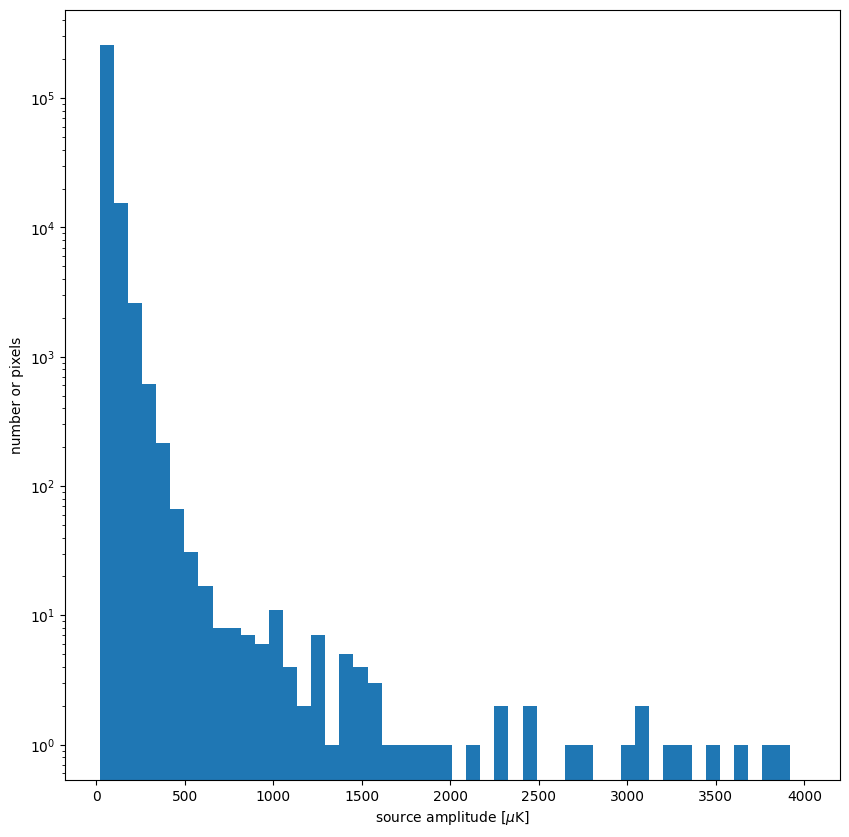

map mean: 14.838049116647777 map rms: 32.994909043270425


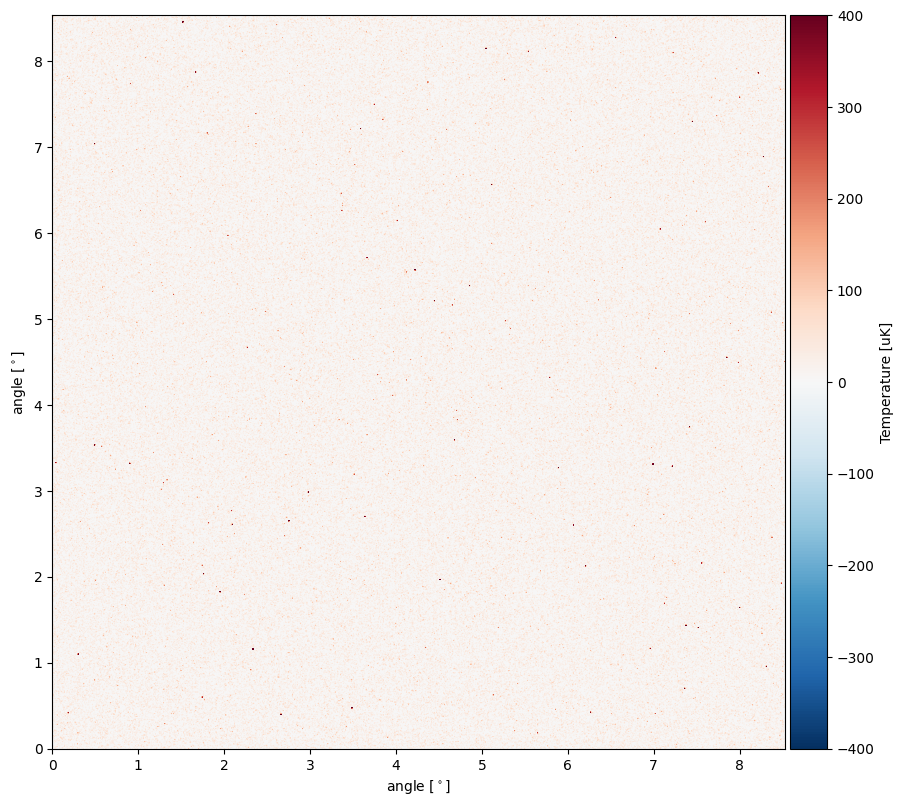

In [3]:
### define brightness bins for flux distributions. these are in units of number of sources per square degree per 
### Kelvin (CMB). normally they are defined in flux units (like per Jansky), but we convert to KCMB at 150 GHz
### so that we can add the simulated maps directly to a CMB realization.

Number_of_Bins = 100
Brightness_Bins = np.zeros([2,Number_of_Bins])
Minimum_Brightness = 0
Maximum_Brightness = 5e-3 # Kelvin
# lower edge of bins
Brightness_Bins[0,:] = np.arange(Number_of_Bins)/Number_of_Bins*(Maximum_Brightness - Minimum_Brightness) + Minimum_Brightness
# upper edge of bins
Brightness_Bins[1,:] = (np.arange(Number_of_Bins) + 1)/Number_of_Bins*(Maximum_Brightness - Minimum_Brightness) + Minimum_Brightness

def AGN_Counts(Brightness_Bins):
    bins_mid = np.sum(Brightness_Bins,0)/2.
    AGN_Counts = 5e4 * (bins_mid/1e-4)**(-1.8)
    return(AGN_Counts)

def DSFG_Counts(Brightness_Bins):
    bins_mid = np.sum(Brightness_Bins,0)/2.
    DSFG_Counts = 1e11*(bins_mid/1e-6)**(-2)*np.exp(-bins_mid/1e-4) + 0.5*(bins_mid/1e-2)**(-2.4)
    return(DSFG_Counts)

def make_source_map(N,pix_size,Brightness_Bins,Counts):
    "makes a realization of a naive Poisson-distributed point source map"
    "takes in the number of pixels, the size of the pixels, the model source counts, and the brightnesses at which the model is defined"
    PSMap = np.zeros([int(N),int(N)])
    area_sqdeg = (N*pix_size/60.)**2
    for i in np.arange(len(Counts)):
        bin = Brightness_Bins[:,i]
        count = Counts[i]
        bin_width = bin[1] - bin[0]
        nsources_mean = count*bin_width*area_sqdeg
        nsources = np.random.poisson(nsources_mean)
        brightnesses = np.random.rand(nsources)*(bin[1] - bin[0]) + bin[0]
        pix_x = N*np.random.rand(nsources)
        pix_y = N*np.random.rand(nsources)
        for j in np.arange(nsources):
            PSMap[int(pix_x[j]),int(pix_y[j])] += brightnesses[j]
    return(PSMap)    
  ############################### 
    
## make a point source map

Counts1 = AGN_Counts(Brightness_Bins)
Counts2 = DSFG_Counts(Brightness_Bins)
PSMap1 = make_source_map(N,pix_size,Brightness_Bins,Counts1) * 1e6 # convert from K to micro-K
PSMap2 = make_source_map(N,pix_size,Brightness_Bins,Counts2) * 1e6 # convert from K to micro-K
PSMap = PSMap1 + PSMap2

hist,bin_edges = np.histogram(PSMap,bins = 50,range=[20, 4e3])
plt.figure(figsize=(10,10))
plt.stairs(hist, bin_edges, fill=True)
plt.yscale('log')
plt.xlabel('source amplitude [$\mu$K]')
plt.ylabel('number or pixels')
plt.show()

p=cmb_modules.Plot_CMB_Map(PSMap,c_min,c_max,X_width,Y_width)    

## 

The top plot shows a histogram of brightness of the pixels in our source map.   The lower plot shows a map of the point source map we have simulated.

<font color='red'>EXERCISE: </font> Plot a histogram of the AGN brightness values and a histogram of the DSFG brightness values.   How do these two distributions differ?

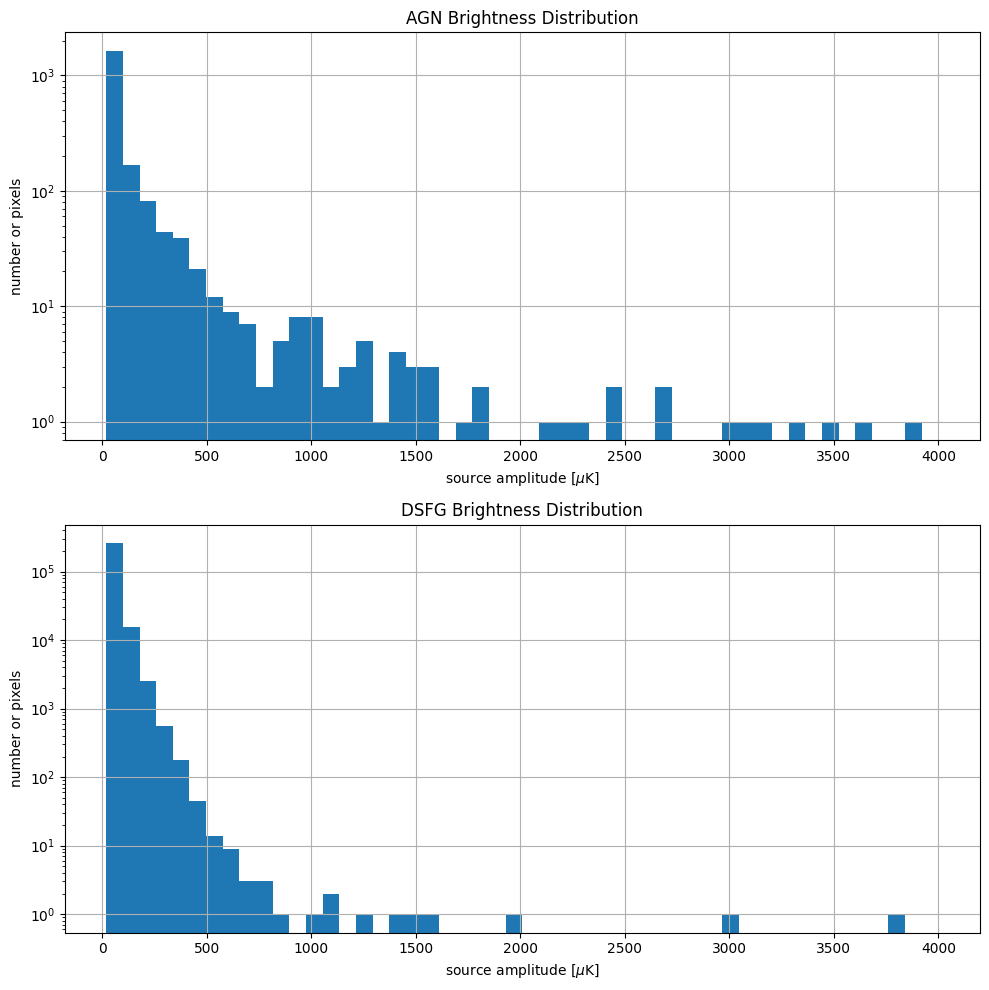

In [10]:
## your code goes here

his_AGN,bin_edges = np.histogram(PSMap1,bins = 50,range=[20, 4e3])
his_DSFG,bin_edges = np.histogram(PSMap2,bins = 50,range=[20, 4e3])
plt.figure(figsize=(10,10))


# Subplot 1: Histogram of AGN brightness
plt.subplot(2, 1, 1)
plt.stairs(his_AGN, bin_edges, fill=True)
plt.yscale('log')
plt.xlabel('source amplitude [$\mu$K]')
plt.ylabel('number or pixels')
plt.title('AGN Brightness Distribution')
plt.grid(True)

# Subplot 2: Histogram of DSFG brightness
plt.subplot(2, 1, 2)
plt.stairs(his_DSFG, bin_edges, fill=True)
plt.yscale('log')
plt.xlabel('source amplitude [$\mu$K]')
plt.ylabel('number or pixels')
plt.title('DSFG Brightness Distribution')
plt.grid(True)

# Display the parallel plots
plt.tight_layout()
plt.show()


Your discussion goes here

#AGN brightness is more spread out,and DSFG is more centered around 0. 

## Section 1.4: SZ Map

Clusters of galaxies imprint a subtle distortion into CMB maps that is most apparent on arcminute scales.    While clusters of galaxies are named after the galaxies bound within them, the galaxies represent only a small fraction of the matter contained within a cluster.   Roughly 80% of the baryons are not contained within galaxies, but rather exist as a cloud of gas bound within the gravitational potential well created by a dark matter halo that caries the vast majority of the mass of the cluster.  Within this well, the dilute gas becomes ionized and heated to temperatures of millions of Kelvin.  Occasionally a CMB photon interacts with one of the hot electrons in this ionized gas.  This interaction (inverse Compton scattering) gives the CMB photon a boost in energy.  Detailed calculations show that this effect (the Sunyev-Zeldovich or SZ effect) leads to decrement of power at frequencies below the 'null' at 220 GHz and extra power at higher frequencies.  This result is redshift independent.  Thus the SZ effect provides a clean way to detect clusters of galaxies and the signal which traces the electron density within the cluster.  The SZ signal is a reasonably good tracer of cluster mass.

For these simulations we treat each cluster as having a brightness "beta profile", and fix each cluster to have an identical angular size.  We draw the distribution of central temperatures from an exponential distribution to simplify the code and reduce the dependance on external libraries.  For more accurate simulations, a range of clusters sizes should be used, a distribution of cluster shapes (with more accurate profiles) should be considered, and the number of clusters as a function of mass and redshift should be chosen to match measurements of the cluster mass function.

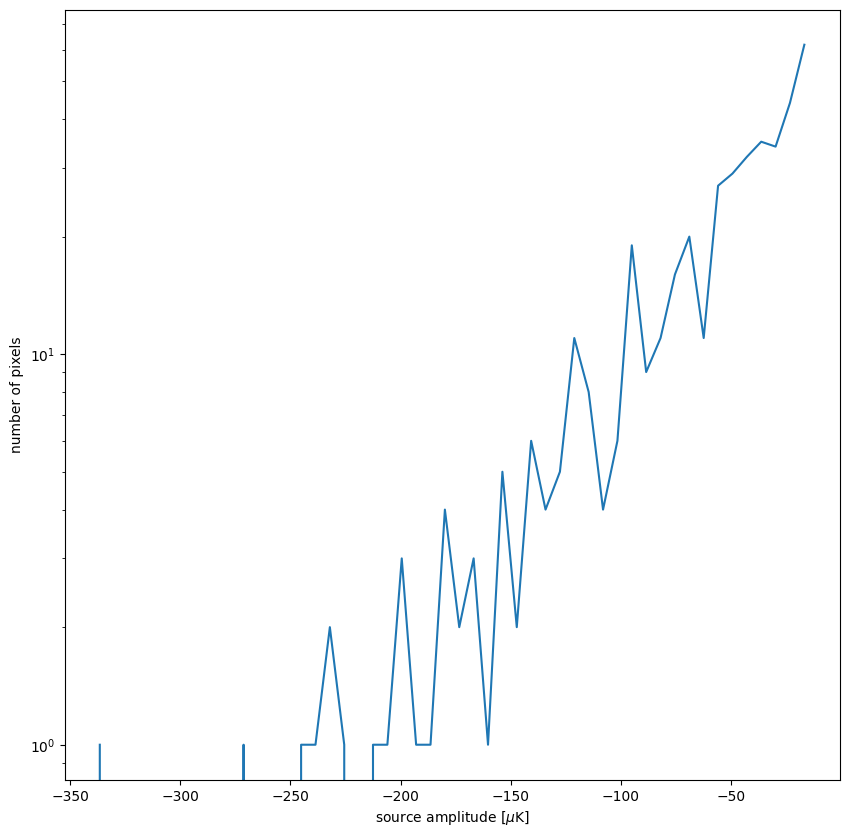

map mean: -14.25528362834187 map rms: 7.196880838376515


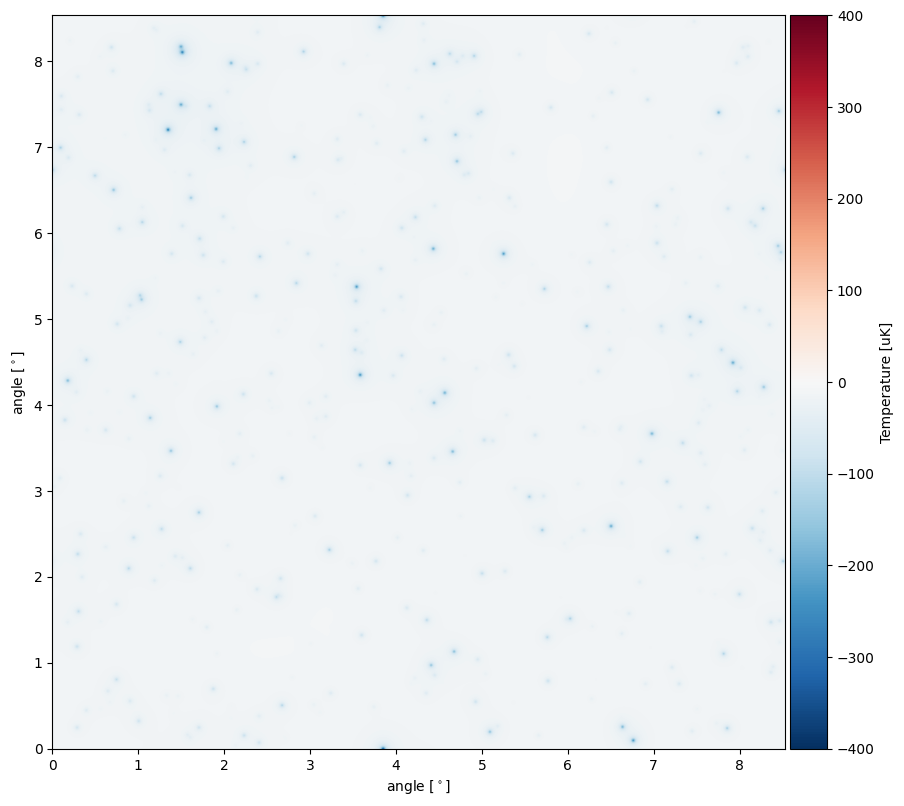

In [18]:
### paramaters to set up the SZ point sources
Number_of_SZ_Clusters  = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
SZ_Theta_core = 1.0

def SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros([N,N])
    SZcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZMap[pix_x,pix_y] += pix_amplitude
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(SZMap,bins = 50,range=[SZMap.min(),-10])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('source amplitude [$\mu$K]')
        plt.ylabel('number of pixels')
        plt.show()
    
    # make a beta function
    beta = beta_function(int(N),pix_size,SZ_beta,SZ_Theta_core)
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZMap)))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map

SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,True)

  
p=cmb_modules.Plot_CMB_Map(SZMap,c_min,c_max,X_width,Y_width)

The top plot shows the a histogram of the SZ-decrements from our simulated SZ cluster map.  The bottom plot shows our simulated SZ map. This map is at 150 GHz. How could you tell just from looking at the code above?

<font color='red'>EXERCISE: </font>  In reality the cluster radii vary from cluster to cluster.  For reference the radius depends on redshift and mass.  The number of clusters as a function of mass and redshift is called the cluster 'mass function' which is a sensitive cosmological proble.  

To enhance the realism of our sims, divide the simulated cluster sample into an extremely large radius sample (1 cluster with a 30 arcminute radius, comparable to the Coma cluster; the largest cluster on the sky), a large radius bin (10%) clusters with 5 arcminute radius), a medium bin (30%) with 2 arcminute radius, and a small bin (60% with 0.5 arcminute radius).  

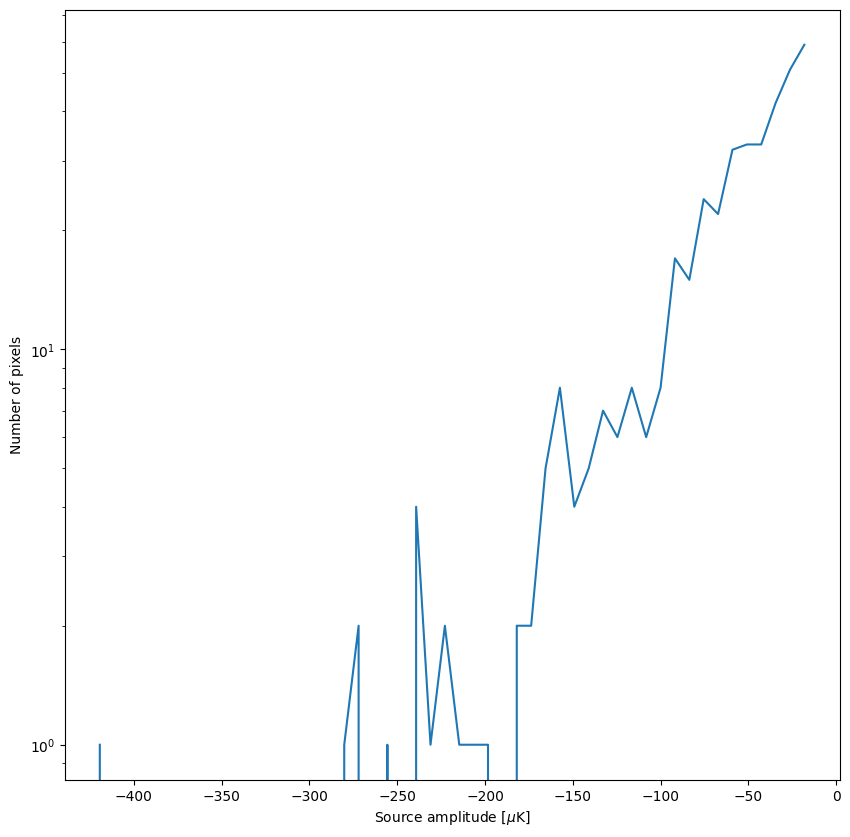

map mean: -0.39093903775231936 map rms: 6.452271411820768


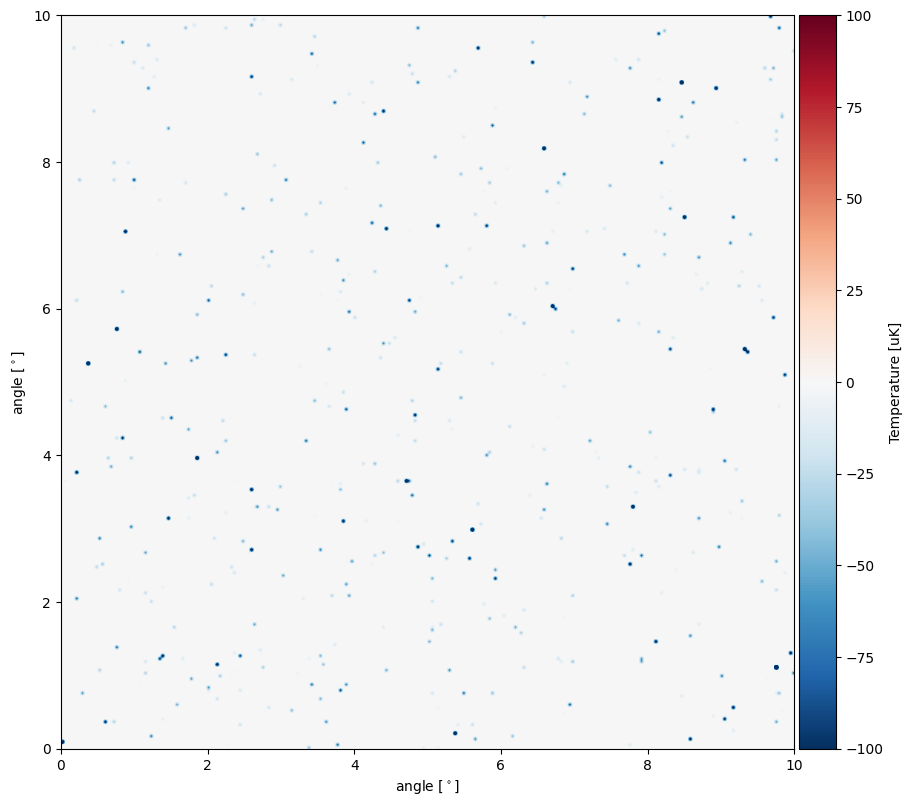

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### Parameters to set up the SZ point sources
Number_of_SZ_Clusters = 500
Mean_Amplitude_of_SZ_Clusters = 50
SZ_beta = 0.86
pix_size = 0.5  # Pixel size in arcminutes
do_plots = True

# Define cluster size bins
def assign_cluster_radius(i, num_clusters):
    if i == 0:
        return 30.0 / 60.0  # Extremely large cluster (30 arcminutes)
    elif i < 0.1 * num_clusters:
        return 5.0 / 60.0   # Large clusters (5 arcminutes)
    elif i < 0.4 * num_clusters:
        return 2.0 / 60.0   # Medium clusters (2 arcminutes)
    else:
        return 0.5 / 60.0   # Small clusters (0.5 arcminutes)

def SZ_source_component(N, pix_size, Number_of_SZ_Clusters, Mean_Amplitude_of_SZ_Clusters, SZ_beta, do_plots):
    """Creates a realization of an SZ map with varying cluster sizes."""
    N = int(N)
    SZMap = np.zeros([N, N])
    SZcat = np.zeros([4, Number_of_SZ_Clusters])  # Catalogue of SZ sources: X, Y, amplitude, radius

    # Generate a distribution of SZ sources with varying amplitude and variance
    for i in range(Number_of_SZ_Clusters):
        pix_x = int(N * np.random.rand())
        pix_y = int(N * np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters) * (-1.0)
        
        # Assign a radius based on the cluster bins
        cluster_radius = assign_cluster_radius(i, Number_of_SZ_Clusters)
        
        # Store the cluster properties in the catalogue
        SZcat[0, i] = pix_x
        SZcat[1, i] = pix_y
        SZcat[2, i] = pix_amplitude
        SZcat[3, i] = cluster_radius
        
        # Add a Gaussian spread to represent the cluster directly on the SZ map
        gaussian_size = int(cluster_radius / pix_size)
        temp_map = np.zeros([N, N])
        temp_map[pix_x, pix_y] = pix_amplitude
        
        # Apply a Gaussian filter with a standard deviation proportional to the radius
        temp_map = gaussian_filter(temp_map, sigma=gaussian_size)
        SZMap += temp_map

    # Plot the histogram of source amplitudes if requested
    if do_plots:
        hist, bin_edges = np.histogram(SZMap, bins=50, range=[SZMap.min(), -10])
        plt.figure(figsize=(10, 10))
        plt.semilogy(bin_edges[0:-1], hist)
        plt.xlabel('Source amplitude [$\mu$K]')
        plt.ylabel('Number of pixels')
        plt.show()
    
    return SZMap, SZcat

### Make a point source map
N = 256  # Adjust this as needed
SZMap, SZCat = SZ_source_component(N, pix_size, Number_of_SZ_Clusters, Mean_Amplitude_of_SZ_Clusters, SZ_beta, do_plots)

# Plot the SZ Map
c_min, c_max = -100, 100  # Adjust as needed for your data
X_width, Y_width = 10, 10
p = cmb_modules.Plot_CMB_Map(SZMap, c_min, c_max, X_width, Y_width)



Comment on the differences between this map and the original version.  And can you think of a reason why (given the algorithm we are using) we didn't draw the cluster radius from a continuous distribution?

## 1.5 Full Sky Map

The sky map is a combination of the CMB anisotropy, a point source map, and an SZ map.  In an appendix we add the impact of CMB lensing.

/Users/yi/Documents/GitHub/Cosmology_Technical_project/cmb_modules.py:15: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


map mean: -18.477852213809253 map rms: 101.88577386809065


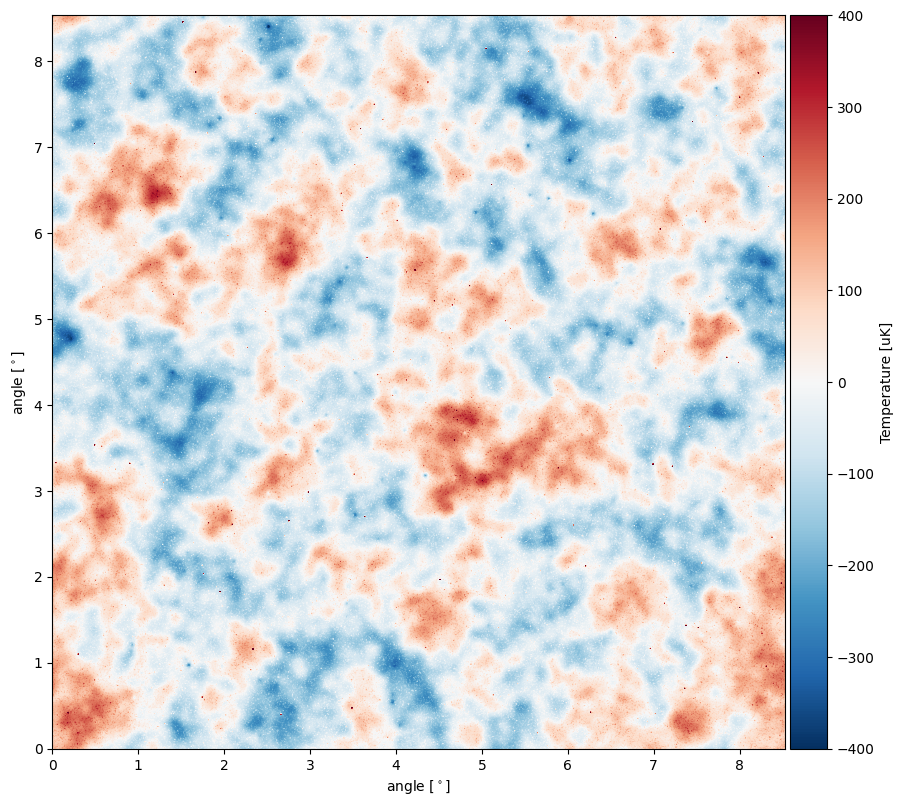

In [13]:
## remake the CMB map from the pervious excercise
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

## add all the components together
total_map = CMB_T + PSMap + SZMap

p=cmb_modules.Plot_CMB_Map(total_map,c_min,c_max,X_width,Y_width)

This plot shows our simulated map that includes CMB, point source, and SZ cluster signals.  Note that the sources seem brighter than what we saw in the real observed maps.   This is not a mistake, as will be seen after we fold in the beam (point spread function) of the instrument.